# I use this notebook to illustrate the baseline for the gesture calssification model and Selection of the final model

# Create Baseline model

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import IterativeImputer

## Data preprocessing

In [4]:
# prepare data
raw_data = pd.read_parquet("../data/uWaveGestures.parquet")

# handle outliers, drop the rows that has the inf values
raw_data = raw_data[~np.isinf(raw_data).any(axis=1)]
inf_or_neg_inf_mask = np.isinf(raw_data) | (raw_data == -np.inf)
print("Total number of inf or -inf values after dropping the inf:")
print(inf_or_neg_inf_mask.sum().sum())

# handle NANs, use multivariate imputation by chained equations
print("Before the MIC imputation....")
print(raw_data.isnull().sum().sum())  # created by cursor
imputer_mice = IterativeImputer(random_state=0)
raw_data = pd.DataFrame(imputer_mice.fit_transform(raw_data), columns=raw_data.columns)
print("NaN values after MICE imputation:")
print(raw_data.isna().sum().sum())

# extract labels from raw data
Y = raw_data.gesture
X = raw_data.drop(columns=["user", "gesture"])

# split raw data to test and evaluation dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

Total number of inf or -inf values after dropping the inf:
0
Before the MIC imputation....
2
NaN values after MICE imputation:
0


- Build Baseline model 

refrence resource used : https://medium.com/@preethi_prakash/understanding-baseline-models-in-machine-learning-3ed94f03d645

Baseline Model Accuracy: 0.1172

Classification Report:
              precision    recall  f1-score   support

         1.0       0.11      0.11      0.11       112
         2.0       0.13      0.13      0.13       112
         3.0       0.11      0.10      0.10       112
         4.0       0.08      0.09      0.09       112
         5.0       0.11      0.10      0.10       112
         6.0       0.12      0.12      0.12       112
         7.0       0.10      0.11      0.10       112
         8.0       0.17      0.18      0.18       112

    accuracy                           0.12       896
   macro avg       0.12      0.12      0.12       896
weighted avg       0.12      0.12      0.12       896



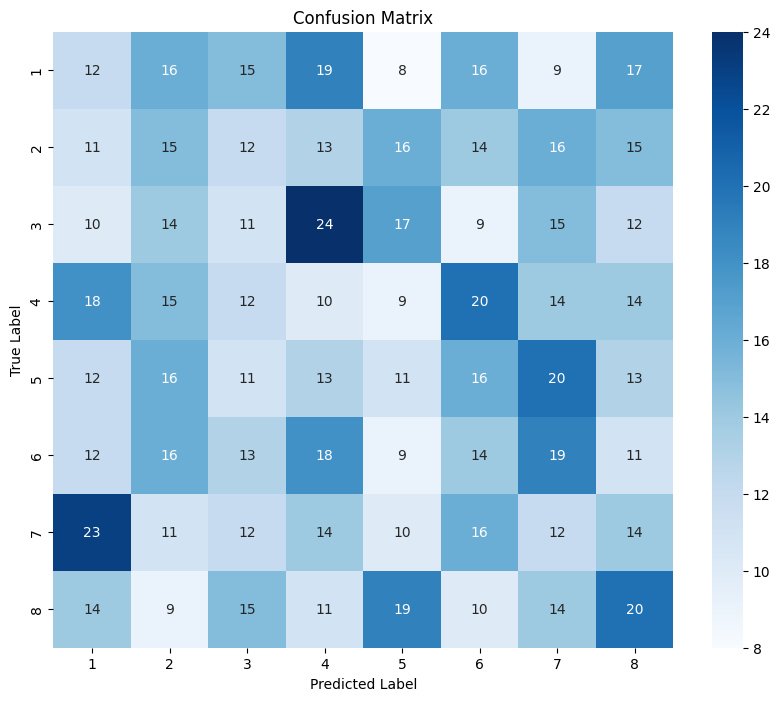

In [5]:
# Use sklearn Dummy module to build the baseline model
# Create and train the baseline model
baseline_model = DummyClassifier(strategy="stratified", random_state=42)
baseline_model.fit(X_train, y_train)

# Make predictions
y_pred = baseline_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline Model Accuracy: {accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(np.arange(8) + 0.5, range(1, 9))
plt.yticks(np.arange(8) + 0.5, range(1, 9))
plt.show()

# After have the baseline model, select among other more complex models for better classification performance

- Try with Gradient Boost model

Gradient Boosting Model Accuracy: 0.8571

Classification Report:
              precision    recall  f1-score   support

         1.0       0.84      0.94      0.89       112
         2.0       0.99      0.96      0.98       112
         3.0       0.82      0.81      0.82       112
         4.0       0.83      0.85      0.84       112
         5.0       0.82      0.86      0.84       112
         6.0       0.84      0.78      0.81       112
         7.0       0.91      0.78      0.84       112
         8.0       0.82      0.88      0.85       112

    accuracy                           0.86       896
   macro avg       0.86      0.86      0.86       896
weighted avg       0.86      0.86      0.86       896



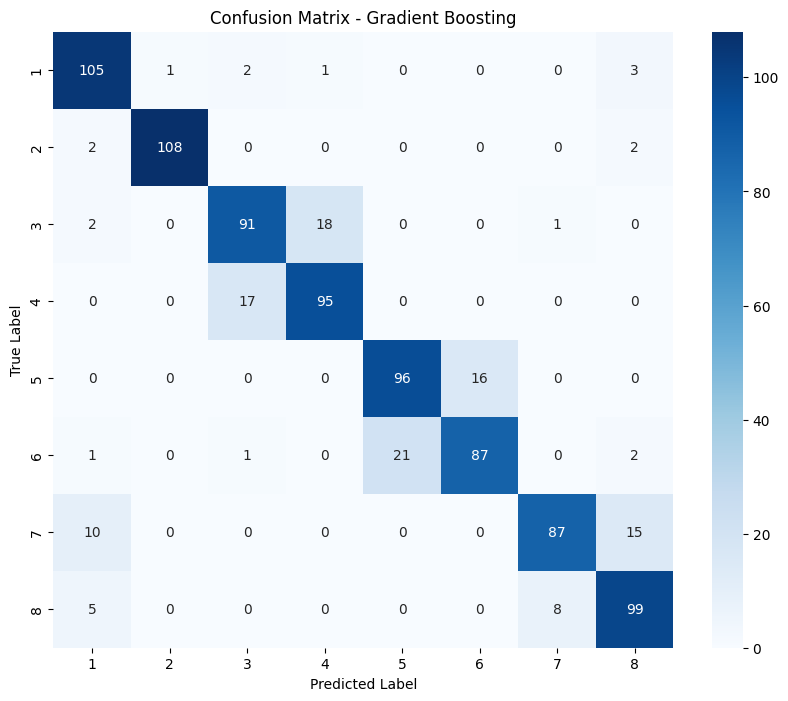

In [6]:
from sklearn.ensemble import GradientBoostingClassifier

# Create and train the Gradient Boosting model
gb_model = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
)
gb_model.fit(X_train, y_train)

# Make predictions
y_pred = gb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Gradient Boosting Model Accuracy: {accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Gradient Boosting")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(np.arange(8) + 0.5, range(1, 9))
plt.yticks(np.arange(8) + 0.5, range(1, 9))
plt.show()

- Try with a shallow NN. 

Refrence resource used : https://medium.com/analytics-vidhya/a-simple-neural-network-classifier-using-pytorch-from-scratch-7ebb477422d2

In [18]:
%env WANDB_API_KEY=""

env: WANDB_API_KEY=""


In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import wandb

wandb.init(project="gesture_classification", name="shallow_nn_experiment")

# Normalize training dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# initlize the hyper parameters
input_dim = X_train_scaled.shape[1]
hidden_dims = [128, 64, 32]  # create a 3 hiden layers model
output_dim = len(np.unique(y_train))
batch_size = 16


class GestureData(Dataset):
    def __init__(self, X, Y):
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values
        if isinstance(Y, pd.Series):
            Y = Y.values
        self.X = torch.FloatTensor(X)
        # PyTorch's loss functions, like CrossEntropyLoss, expect class labels to be in the range 0 to (num_classes - 1).
        self.Y = torch.LongTensor(Y) - 1

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


train_dataset = GestureData(X_train_scaled, y_train)
test_dataset = GestureData(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Write the shallow NN from scratch
class ShallowNet(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.3):
        super(ShallowNet, self).__init__()
        layers = []
        for h in hidden_dims:
            layers.extend(
                [
                    nn.Linear(input_dim, h),
                    nn.ReLU(),
                    nn.BatchNorm1d(h),
                    nn.Dropout(dropout_rate),
                ]
            )
            input_dim = h
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


model = ShallowNet(input_dim, hidden_dims, output_dim)

print(model.parameters)

<bound method Module.parameters of ShallowNet(
  (layers): Sequential(
    (0): Linear(in_features=48, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=8, bias=True)
  )
)>


In [16]:
learning_rate = 0.01
momentum = 0.9
num_epochs = 1000
# define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
# Log model architecture and hyperparameters
wandb.watch(model, log="all")
wandb.config.update(
    {
        "learning_rate": learning_rate,
        "momentum": momentum,
        "epochs": num_epochs,
        "batch_size": batch_size,
        "hidden_dim": hidden_dims,
        "input_dim": input_dim,
        "output_dim": output_dim,
    }
)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Log training loss every 100 batches
        if i % 100 == 99:
            wandb.log(
                {
                    "batch": epoch * len(train_loader) + i,
                    "train_loss": running_loss / 100,
                }
            )
            running_loss = 0.0

    # Evaluation
    model.eval()
    eval_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            eval_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average evaluation loss and accuracy
    avg_eval_loss = eval_loss / len(test_loader)
    accuracy = 100 * correct / total

    # Log evaluation metrics
    wandb.log({"epoch": epoch, "eval_loss": avg_eval_loss, "accuracy": accuracy})

    # Print epoch statistics
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, "
            f"Eval Loss: {avg_eval_loss:.4f}, Accuracy: {accuracy:.2f}%"
        )

# Close wandb run
wandb.finish()

Epoch [10/1000], Train Loss: 0.0666, Eval Loss: 0.4356, Accuracy: 80.80%
Epoch [20/1000], Train Loss: 0.0611, Eval Loss: 0.3741, Accuracy: 84.60%
Epoch [30/1000], Train Loss: 0.0559, Eval Loss: 0.3657, Accuracy: 84.38%
Epoch [40/1000], Train Loss: 0.0614, Eval Loss: 0.3114, Accuracy: 86.27%
Epoch [50/1000], Train Loss: 0.0453, Eval Loss: 0.3065, Accuracy: 86.38%
Epoch [60/1000], Train Loss: 0.0453, Eval Loss: 0.2873, Accuracy: 87.28%
Epoch [70/1000], Train Loss: 0.0444, Eval Loss: 0.2951, Accuracy: 87.95%
Epoch [80/1000], Train Loss: 0.0354, Eval Loss: 0.3039, Accuracy: 86.94%
Epoch [90/1000], Train Loss: 0.0509, Eval Loss: 0.3048, Accuracy: 87.28%
Epoch [100/1000], Train Loss: 0.0423, Eval Loss: 0.2962, Accuracy: 86.94%
Epoch [110/1000], Train Loss: 0.0449, Eval Loss: 0.2889, Accuracy: 87.95%
Epoch [120/1000], Train Loss: 0.0412, Eval Loss: 0.2772, Accuracy: 88.06%
Epoch [130/1000], Train Loss: 0.0343, Eval Loss: 0.2689, Accuracy: 89.06%
Epoch [140/1000], Train Loss: 0.0347, Eval Loss

accuracy,▁▃▄▄▅▅▆▄▅▅▆▇▆▅▆▆▇▆▇▆▇▇▇▆▇▇▇█▆█▆▆▆▇▆█▇▇▇▇
batch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇████
epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇███
eval_loss,█▆▅▄▃▃▂▂▂▂▂▁▁▂▁▂▁▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▅▆▆▅▄▅▃▄▃▂▃▃▄▃▃▃▂▂▃▁▃▂▂▁▂▂▃▂▁▂▁▃▁▁▂▃▂
accuracy,90.17857
batch,223975
epoch,999
eval_loss,0.2635
train_loss,0.26327


In [19]:
# Evaluation on test data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")

# Print some additional information for debugging
print(f"Number of classes: {output_dim}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Accuracy on test set: 90.18%
Number of classes: 8
Shape of X_train: (3583, 48)
Shape of y_train: (3583,)
